## Importing the libraries and Creating Dataset

In [1]:
# Importing all the relevant libraries for the program
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from collections import Counter

In [2]:
# Representing the dataset given in the PDF
data = {
    "Weather": ["sunny","sunny","windy","rainy","rainy","rainy","windy","windy","windy","sunny","sunny"],
    "Parents": ["visit","no-visit","visit","visit","no-visit","visit","no-visit","no-visit","visit","no-visit","no-visit"],
    "Cash": ["rich","rich","rich","poor","rich","poor","poor","rich","rich","rich","poor"],
    "Exam": ["yes","no","no","yes","no","no","yes","yes","no","no","yes"],
    "Activity": ["cinema","tennis","cinema","cinema","stay-in","cinema","cinema","shopping","cinema","tennis","tennis"]
}

df = pd.DataFrame(data)
df

,Weather,Parents,Cash,Exam,Activity
0,sunny,visit,rich,yes,cinema
1,sunny,no-visit,rich,no,tennis
2,windy,visit,rich,no,cinema
3,rainy,visit,poor,yes,cinema
4,rainy,no-visit,rich,no,stay-in
5,rainy,visit,poor,no,cinema
6,windy,no-visit,poor,yes,cinema
7,windy,no-visit,rich,yes,shopping
8,windy,visit,rich,no,cinema
9,sunny,no-visit,rich,no,tennis


In [3]:
# Scope and Validation to ensure all values are within expected domain
VALID_VALUES = {
    "Weather": {"sunny", "windy", "rainy"},
    "Parents": {"visit", "no-visit"},
    "Cash": {"rich", "poor"},
    "Exam": {"yes", "no"},
    "Activity": {"cinema", "tennis", "stay-in", "shopping"}
}

def validate_dataset(df, valid_values):
    errors = []
    for col, valid_set in valid_values.items():
        if col not in df.columns:
            errors.append(f"Missing column: {col}")
            continue
        out_of_scope = set(df[col].unique()) - valid_set
        if out_of_scope:
            errors.append(f"Column '{col}' has out-of-scope values: {out_of_scope}")
    if errors:
        for e in errors:
            print(f"[VALIDATION ERROR] {e}")
        raise ValueError("Dataset contains invalid values. Please fix before proceeding.")
    else:
        print("[VALIDATION PASSED] All values are within expected scope.")

validate_dataset(df, VALID_VALUES)

[VALIDATION PASSED] All values are within expected scope.


# Question 1

## CART Implementation using sklearn

In [4]:
# Since CART only accepts numerical values, encoding the categorical values into numbers
encoders = {}

for column in df.columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    encoders[column] = le

df

,Weather,Parents,Cash,Exam,Activity
0,1,1,1,1,0
1,1,0,1,0,3
2,2,1,1,0,0
3,0,1,0,1,0
4,0,0,1,0,2
5,0,1,0,0,0
6,2,0,0,1,0
7,2,0,1,1,1
8,2,1,1,0,0
9,1,0,1,0,3


In [5]:
# Training the model and Testing
X = df.drop("Activity", axis=1)
y = df["Activity"]

model = DecisionTreeClassifier(criterion="gini", random_state=0)
model.fit(X, y)

y_pred = model.predict(X)

cart_accuracy = accuracy_score(y, y_pred)

print("CART Training Accuracy:", round(cart_accuracy, 4))

CART Training Accuracy: 1.0


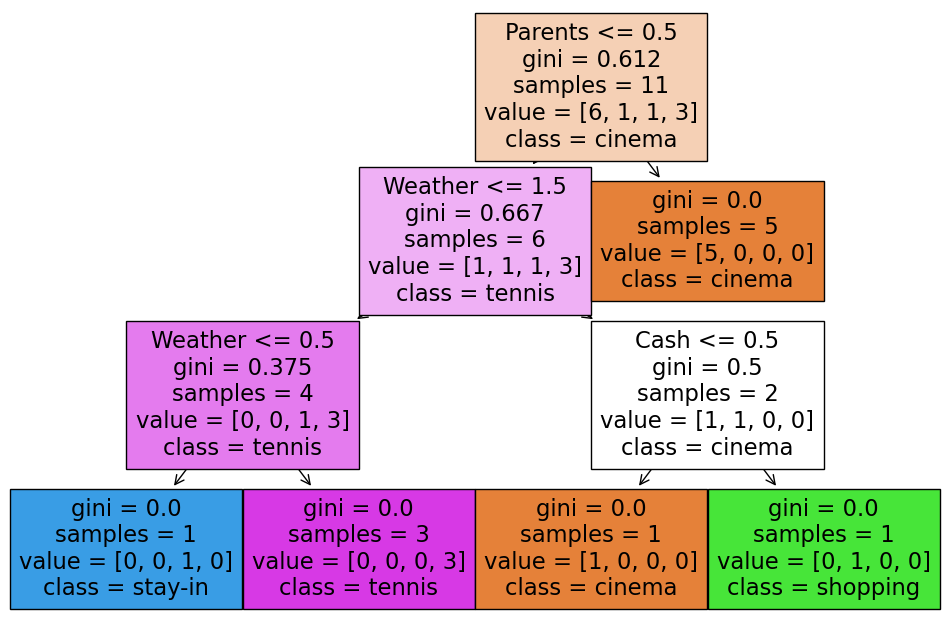

In [6]:
# Plotting what the Decision Tree constructed by CART looks like
plt.figure(figsize=(12,8))
plot_tree(model,
          feature_names=X.columns,
          class_names=encoders["Activity"].classes_,
          filled=True)
plt.show()

## ID3 Implementation

In [7]:
# Helper function for accuracy prediction for both ID3 and C4.5 Implementation, since I cannot use sklearn inbuilt function
def predict(tree, instance):
    if not isinstance(tree, dict):
        return tree
    
    attr = next(iter(tree))
    value = instance[attr]
    
    if value in tree[attr]:
        return predict(tree[attr][value], instance)
    else:
        return None

In [8]:
# Recreate original categorical dataframe since I can use it with ID3 and C4.5
data = {
    "Weather": ["sunny","sunny","windy","rainy","rainy","rainy","windy","windy","windy","sunny","sunny"],
    "Parents": ["visit","no-visit","visit","visit","no-visit","visit","no-visit","no-visit","visit","no-visit","no-visit"],
    "Cash": ["rich","rich","rich","poor","rich","poor","poor","rich","rich","rich","poor"],
    "Exam": ["yes","no","no","yes","no","no","yes","yes","no","no","yes"],
    "Activity": ["cinema","tennis","cinema","cinema","stay-in","cinema","cinema","shopping","cinema","tennis","tennis"]
}

df_id3 = pd.DataFrame(data)

In [9]:
# Scope and Validation to ensure all values are within expected domain
VALID_VALUES = {
    "Weather": {"sunny", "windy", "rainy"},
    "Parents": {"visit", "no-visit"},
    "Cash": {"rich", "poor"},
    "Exam": {"yes", "no"},
    "Activity": {"cinema", "tennis", "stay-in", "shopping"}
}

def validate_dataset(df, valid_values):
    errors = []
    for col, valid_set in valid_values.items():
        if col not in df.columns:
            errors.append(f"Missing column: {col}")
            continue
        out_of_scope = set(df[col].unique()) - valid_set
        if out_of_scope:
            errors.append(f"Column '{col}' has out-of-scope values: {out_of_scope}")
    if errors:
        for e in errors:
            print(f"[VALIDATION ERROR] {e}")
        raise ValueError("Dataset contains invalid values. Please fix before proceeding.")
    else:
        print("[VALIDATION PASSED] All values are within expected scope.")

validate_dataset(df_id3, VALID_VALUES)

[VALIDATION PASSED] All values are within expected scope.


In [10]:
# Calculate the Entropy for ID3
def entropy(y):
    counts = Counter(y)
    total = len(y)
    ent = 0
    
    for count in counts.values():
        p = count / total
        ent -= p * math.log2(p)
    
    return ent

In [11]:
# Calculate the Information Gain for ID3
def information_gain(df, attribute, target):
    
    total_entropy = entropy(df[target])
    
    values = df[attribute].unique()
    weighted_entropy = 0
    
    for value in values:
        subset = df[df[attribute] == value]
        weight = len(subset) / len(df)
        weighted_entropy += weight * entropy(subset[target])
    
    return total_entropy - weighted_entropy

In [12]:
# ID3 Algorithm Implementation
def id3(df, attributes, target):
    
    # If all examples have same label → return that label
    if len(df[target].unique()) == 1:
        return df[target].iloc[0]
    
    # If no attributes left → return majority class
    if len(attributes) == 0:
        return df[target].mode()[0]
    
    # Compute Information Gain for each attribute
    gains = {}
    for attr in attributes:
        gains[attr] = information_gain(df, attr, target)
    
    # Select best attribute
    best_attr = max(gains, key=gains.get)
    
    tree = {best_attr: {}}
    
    # Build subtree for each value
    for value in df[best_attr].unique():
        subset = df[df[best_attr] == value]
        
        if subset.empty:
            tree[best_attr][value] = df[target].mode()[0]
        else:
            remaining_attrs = [a for a in attributes if a != best_attr]
            tree[best_attr][value] = id3(subset, remaining_attrs, target)
    
    return tree

In [13]:
# Running the ID3 Algorithm and calculating Accuracy
attributes = ["Weather", "Parents", "Cash", "Exam"]
target = "Activity"

tree = id3(df_id3, attributes, target)

correct = 0

for _, row in df_id3.iterrows():  # if you want original 11 rows
    prediction = predict(tree, row)
    if prediction == row["Activity"]:
        correct += 1

id3_accuracy = correct / 11

print("ID3 Training Accuracy:", round(id3_accuracy, 4))

ID3 Training Accuracy: 1.0


In [14]:
# Printing the Decision Tree formed by ID3
def print_tree(tree, indent=""):
    if not isinstance(tree, dict):
        print(indent + "->", tree)
        return
    
    for attr, branches in tree.items():
        for value, subtree in branches.items():
            print(indent + f"{attr} = {value}")
            print_tree(subtree, indent + "   ")

print_tree(tree)

Weather = sunny
   Parents = visit
      -> cinema
   Parents = no-visit
      -> tennis
Weather = windy
   Parents = visit
      -> cinema
   Parents = no-visit
      Cash = poor
         -> cinema
      Cash = rich
         -> shopping
Weather = rainy
   Parents = visit
      -> cinema
   Parents = no-visit
      -> stay-in


## Implementation of C4.5

In [15]:
# Calculate Split Information for C4.5
def split_info(df, attribute):
    total = len(df)
    values = df[attribute].unique()
    
    si = 0
    for value in values:
        subset = df[df[attribute] == value]
        proportion = len(subset) / total
        si -= proportion * math.log2(proportion)
    
    return si

In [16]:
# Calculate Gain Ratio for C4.5
def gain_ratio(df, attribute, target):
    
    ig = information_gain(df, attribute, target)
    si = split_info(df, attribute)
    
    if si == 0:
        return 0   # avoid division by zero
    
    return ig / si

In [17]:
# Implementation  of C4.5 Algorithm
def c45(df, attributes, target):
    
    # If all examples have same label
    if len(df[target].unique()) == 1:
        return df[target].iloc[0]
    
    # If no attributes left
    if len(attributes) == 0:
        return df[target].mode()[0]
    
    # Compute Gain Ratio for each attribute
    ratios = {}
    for attr in attributes:
        ratios[attr] = gain_ratio(df, attr, target)
    
    # Select attribute with highest Gain Ratio
    best_attr = max(ratios, key=ratios.get)
    
    tree = {best_attr: {}}
    
    for value in df[best_attr].unique():
        subset = df[df[best_attr] == value]
        
        if subset.empty:
            tree[best_attr][value] = df[target].mode()[0]
        else:
            remaining_attrs = [a for a in attributes if a != best_attr]
            tree[best_attr][value] = c45(subset, remaining_attrs, target)
    
    return tree

In [18]:
# Running the C4.5 Algorithm and calculating Accuracy
attributes = ["Weather", "Parents", "Cash", "Exam"]
target = "Activity"

c45_tree = c45(df_id3, attributes, target)

c45_tree

correct = 0

for _, row in df_id3.iterrows():
    prediction = predict(c45_tree, row)
    if prediction == row["Activity"]:
        correct += 1

c45_accuracy = correct / len(df_id3)

print("C4.5 Training Accuracy:", round(c45_accuracy, 4))

C4.5 Training Accuracy: 1.0


In [19]:
# Printing the Decision Tree formed by C4.5
print_tree(c45_tree)

Parents = visit
   -> cinema
Parents = no-visit
   Weather = sunny
      -> tennis
   Weather = rainy
      -> stay-in
   Weather = windy
      Cash = poor
         -> cinema
      Cash = rich
         -> shopping


# Question 2

## Matching Information Gain of 2 Attributes

In [20]:
# Printing the current Information Gain of all the Attributes in the DataSet
attributes = ["Weather", "Parents", "Cash", "Exam"]
target = "Activity"

print("Information Gain for each attribute:\n")

for attr in attributes:
    ig = information_gain(df_id3, attr, target)
    print(f"{attr}: {round(ig, 4)}")

Information Gain for each attribute:

Weather: 0.7767
Parents: 0.6395
Cash: 0.1498
Exam: 0.1981


In [21]:
# Selecting the attributes "Weather" and "Parents" to match Information Gain
# Lowering the Information Gain of "Weather" to match "Parents", hence adding the appropriate instance
new_row = {
    "Weather": "sunny",
    "Parents": "no-visit",
    "Cash": "rich",
    "Exam": "no",
    "Activity": "shopping"
}

df_id3 = pd.concat([df_id3, pd.DataFrame([new_row])], ignore_index=True)

df_id3

,Weather,Parents,Cash,Exam,Activity
0,sunny,visit,rich,yes,cinema
1,sunny,no-visit,rich,no,tennis
2,windy,visit,rich,no,cinema
3,rainy,visit,poor,yes,cinema
4,rainy,no-visit,rich,no,stay-in
5,rainy,visit,poor,no,cinema
6,windy,no-visit,poor,yes,cinema
7,windy,no-visit,rich,yes,shopping
8,windy,visit,rich,no,cinema
9,sunny,no-visit,rich,no,tennis


In [22]:
# The Information Gain of the 2 selected attributes have matched
attributes = ["Weather", "Parents", "Cash", "Exam"]
target = "Activity"

print("Information Gain for each attribute:\n")

for attr in attributes:
    ig = information_gain(df_id3, attr, target)
    print(f"{attr}: {round(ig, 4)}")

Information Gain for each attribute:

Weather: 0.6583
Parents: 0.6549
Cash: 0.1887
Exam: 0.0836


In [23]:
# New ID3-based Decision Tree based on the modified DataSet (with the new instance added)
tree_after = id3(df_id3, attributes, target)
print_tree(tree_after)

Weather = sunny
   Parents = visit
      -> cinema
   Parents = no-visit
      Cash = rich
         Exam = no
            -> tennis
      Cash = poor
         -> tennis
Weather = windy
   Parents = visit
      -> cinema
   Parents = no-visit
      Cash = poor
         -> cinema
      Cash = rich
         -> shopping
Weather = rainy
   Parents = visit
      -> cinema
   Parents = no-visit
      -> stay-in


# Question 3

## Constructing the tree based on these 2 attributes

In [24]:
# Constructing an ID3-based Decision Tree considering only the attributes "Weather" and "Parents"
two_attributes = ["Weather", "Parents"]
target = "Activity"

tree_two = id3(df_id3, two_attributes, target)

print("Two-Attribute Decision Tree:\n")
print_tree(tree_two)

Two-Attribute Decision Tree:

Weather = sunny
   Parents = visit
      -> cinema
   Parents = no-visit
      -> tennis
Weather = windy
   Parents = visit
      -> cinema
   Parents = no-visit
      -> cinema
Weather = rainy
   Parents = visit
      -> cinema
   Parents = no-visit
      -> stay-in


In [25]:
# Accuracy based on the tree constructed with the 2 selected attributes
correct = 0

for _, row in df_id3.iterrows():
    prediction = predict(tree_two, row)
    if prediction == row["Activity"]:
        correct += 1

accuracy = correct / len(df_id3)

print("Accuracy with Weather & Parents:", round(accuracy, 4))

Accuracy with Weather & Parents: 0.8333
